In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os.path
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from ARIMA_PermEnt import weighted_perm_entropy, min_weighted_perm_entropy
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
# from pyentrp import entropy as ent
import math
# import plotly.graph_objs as go
import time
plt.style.use('seaborn-whitegrid')
plt.rcParams['text.usetex'] = True
%matplotlib inline  

In [14]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [15]:
#most significant autocorrelation lag
def max_lag_autocorr(ts,lags=7):
    ac1 = 0
    max_lag = 0
    for i in range(1,lags+1):
        ac = np.abs(ts.autocorr(lag=i))
        if ac > ac1:
            ac1 = ac
            max_lag = i
    return max_lag , ac1

In [16]:

def sample_entropy_autocorr_window(df, window=52, n_samples = 100, p_sample = [0.8, 0.5, 0.1]):
    states = df.columns[2:]
    results = []
    for state in states:
        print(state)
        ts = df[state]
        first_idx = ts.first_valid_index()
        last_idx = ts.last_valid_index()
        ts = ts[first_idx:last_idx]
        if ts.shape[0]<= 0:
            continue
        #discard ts with too many NA
        na_per = ts.dropna().shape[0]/ts.shape[0]
        if na_per<0.2:
            continue
        n = ts.dropna().shape[0]
        if n < window:
            continue
        k = 0
        while k < n_samples:
            k+=1
            start = np.random.randint(n-window)
            ts_window = ts[start:start+window]
            #discard ts with too many NA
            na_per = ts_window.dropna().shape[0]/ts_window.shape[0]
            if na_per<0.75:
                continue
            order, delay = min_weighted_perm_entropy(ts_window, min_order=2, max_order=5,min_delay=1, max_delay=7, normalize=True)
            entropy_real = weighted_perm_entropy(ts_window, order=order,delay=delay, normalize=True)
            max_lag, autocorr =  max_lag_autocorr(ts_window,lags=15)
            var = np.var(ts_window)
            mean = np.mean(ts_window)
            for p in p_sample:
                ts_sample = ts_window.apply(lambda x: np.random.binomial(x, p, size = 1)[0] if not np.isnan(x) else None )
                entropy_sample = weighted_perm_entropy(ts_sample, order=order,delay=delay, normalize=True)
                autcorr_sample = np.abs(ts_sample.autocorr(lag=max_lag))
                results.append([state,entropy_sample,entropy_real,entropy_sample/entropy_real,order,p, autocorr, autcorr_sample, max_lag,var,mean])
#                 print(state, entropy, entropy_sample, order, autocorr, autcorr_sample, max_lag)
    
    df = pd.DataFrame.from_records(results,columns=['state','entropy_sample','entropy','ratio','order','sample_rate','autocorr','autcorr_sample','max_lag','var','mean']).dropna()
    print('finished')
    return df



In [43]:
#sample external and GT timeseries and compute correlation between them
def sample_ext_corr_window(influenza_df, google_df, window=52, n_samples = 100, p_sample = [0.8, 0.5, 0.1]):
    
    states = influenza_df.columns
    start_day = max(influenza_df.index.min(),google_df.index.min())
    end_date = min(influenza_df.index.max(),google_df.index.max())
    day_range = pd.date_range(start_day, end_date, freq='W')
    p_ex = 0.5
    results = []
    for state in states:
        if not state in google_df.columns:
            continue
        print(state)
        
        ts = influenza_df[state]
        ts_ex = google_df[state]

        ts = ts.reindex(day_range,fill_value=None)
        ts_ex = ts_ex.reindex(day_range,fill_value=None)
        n = ts.shape[0]
        
        k = 0
        while k < n_samples:
            k+=1
            start = np.random.randint(n-window)
            ts_window = ts[start:start+window]
            ts_window_ex = ts_ex[start:start+window]

            corr = np.abs(ts_window.corr(ts_window_ex))
            cov = np.abs(ts_window.cov(ts_window_ex))
            var = np.var(ts_window)
            mean = np.mean(ts_window)
            for p in p_sample:
                for p_ex in p_sample:
                    ts_sample = ts_window.apply(lambda x: np.random.binomial(x, p, size = 1)[0] if not np.isnan(x) else None )
                    ts_window_ex_sample = ts_window_ex.apply(lambda x: np.random.binomial(x, p_ex, size = 1)[0] if not np.isnan(x) else None )
                    cov_sample = np.abs(ts_sample.cov(ts_window_ex_sample))
                    corr_sample = np.abs(ts_sample.corr(ts_window_ex_sample))
                    results.append([state,p, p_ex, corr, corr_sample,cov, cov_sample,var,mean])
    
    df = pd.DataFrame.from_records(results,columns=['state','sample_rate','sample_rate_ext','corr','corr_sample','cov','cov_sample','var','mean']).dropna()
    print('finished')
    return df


In [17]:
#Functions to plot Figures
def plot_entropy(df_results,p_sample, label):
    df1 = df_results[df_results.disease==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [df['entropy'][p_sample[0]]]+[df['entropy_sample'][p] for p in p_sample]
    plt.plot(x,y,label=label, linewidth=2)
    y_q1 = [df_q1['entropy'][p_sample[0]]]+[df_q1['entropy_sample'][p] for p in p_sample]
    y_q3 = [df_q3['entropy'][p_sample[0]]]+[df_q3['entropy_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1)
    

def plot_autocorr(df_results, p_sample, label):
    df1 = df_results[df_results.disease==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [df['autocorr'][p_sample[0]]]+[df['autcorr_sample'][p] for p in p_sample]
    plt.plot(x,y,label=label, linewidth=2)
    y_q1 = [df_q1['autocorr'][p_sample[0]]]+[df_q1['autcorr_sample'][p] for p in p_sample]
    y_q3 = [df_q3['autocorr'][p_sample[0]]]+[df_q3['autcorr_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 

    
    
def plot_entropy_ratio(df_results, p_sample, label):
    df1 = df_results[df_results.disease==label]
    df1['ratio'] =  df1['entropy_sample']/df1['entropy']
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [1.]+[df['ratio'][p] for p in p_sample]
    plt.plot(x,y,label=label,linewidth=2)
    y_q1 = [1.0]+[df_q1['ratio'][p] for p in p_sample]
    y_q3 = [1.0]+[df_q3['ratio'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1)    
    
    
def plot_autocorr_ratio(df_results, p_sample, label):
    df1 = df_results[df_results.disease==label]
    df1['ratio'] =  df1['autcorr_sample']/df1['autocorr']
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [1.]+[df['ratio'][p] for p in p_sample]
    plt.plot(x,y,label=label, linewidth=2)
    y_q1 = [1.]+[df_q1['ratio'][p] for p in p_sample]
    y_q3 = [1.]+[df_q3['ratio'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 
    
    
def plot_autocorr_theoretical(df_results, p_sample, label, color):
    df1 = df_results[df_results.disease==label]
    df1['x_norm'] *= df1['autocorr']
    df = df1.groupby(['sample_rate']).mean()
#     df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q1 = df1.groupby(['sample_rate']).mean()+df1.groupby(['sample_rate']).std()
#     df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    df_q3 = df1.groupby(['sample_rate']).mean()-df1.groupby(['sample_rate']).std()
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [df['autocorr'][p_sample[0]]]+[df['autcorr_sample'][p] for p in p_sample]
    y_t = [df['autocorr'][p_sample[0]]]+[df['x_norm'][p] for p in p_sample]
    
    y_q1 = [df_q1['autocorr'][p_sample[0]]]+[df_q1['x_norm'][p] for p in p_sample]
    y_q3 = [df_q3['autocorr'][p_sample[0]]]+[df_q3['x_norm'][p] for p in p_sample]
    
    plt.fill_between(x, y_q1, y_q3, alpha=0.1)  
    plt.plot(x,y_t,linewidth=2,alpha=1, c=color)
    plt.plot(x,y,'o', markersize=8, alpha=1, c=color, label=label)
    


In [46]:
#Functions to plot Figures with external signal
def plot_cov_ext(df_results, p_sample):
#     df1 = df_results[df_results.state==label]
    df1 = df_results
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = p_sample
    y = [df['cov_sample'][p] for p in p_sample]
    plt.plot(x,y, linewidth=2)
    y_q1 = [df_q1['cov_sample'][p] for p in p_sample]
    y_q3 = [df_q3['cov_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 

def plot_cov_ext_states(df_results, p_sample,label):
    df1 = df_results[df_results.state==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = p_sample
    y = [df['cov_sample'][p] for p in p_sample]
    plt.plot(x,y, linewidth=1, label=label)
    y_q1 = [df_q1['cov_sample'][p] for p in p_sample]
    y_q3 = [df_q3['cov_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.05) 
    
    return x,y
    
def plot_corr_ext(df_results, p_sample):
#     df1 = df_results[df_results.state==label]
    df1 = df_results
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x =  p_sample
    y = [df['corr_sample'][p] for p in p_sample]
    plt.plot(x,y, linewidth=2)
    y_q1 = [df_q1['corr_sample'][p] for p in p_sample]
    y_q3 = [df_q3['corr_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 
    
    return x,y

def plot_corr_ext_states(df_results, p_sample,label):
    df1 = df_results[df_results.state==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = p_sample
    y = [df['corr_sample'][p] for p in p_sample]
    plt.plot(x,y, linewidth=1, label=label)
    y_q1 = [df_q1['corr_sample'][p] for p in p_sample]
    y_q3 = [df_q3['corr_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.05) 
    
    return x,y

In [47]:
#reads data and computes predictability measures
def compute_predictability(window= 52, n_samples=100, p_sample = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05, 0.01]):
    data_folder = Path('Data/epidemics/')
    hepatitis_df = pd.read_csv(data_folder/"HEPATITIS_A_Cases_1966-2014_20160707103116.csv",skiprows=2, na_values="-")
    influenza_df = pd.read_csv(data_folder/"INFLUENZA_Cases_1919-1951_20151014132002.csv",skiprows=2, na_values="-")
    measles_df = pd.read_csv(data_folder/"MEASLES_Cases_1909-2001_20150923120449.csv", na_values="-")
    chlamydia_df = pd.read_csv(data_folder/"CHLAMYDIA_Cases_2006-2014_20160707103149.csv",skiprows=2, na_values="-")
    polio_df = pd.read_csv(data_folder/"POLIOMYELITIS_Cases_1921-1971_20150923114821.csv",skiprows=2, na_values="-")
    gonorrhea_df = pd.read_csv(data_folder/"GONORRHEA_Cases_1972-2014_20160707103202.csv",skiprows=2, na_values="-")
    mumps_df = pd.read_csv(data_folder/"MUMPS_Cases_1967-2014_20160707103045.csv",skiprows=2, na_values="-")
    whooping_df = pd.read_csv(data_folder/"WHOOPING_COUGH_[PERTUSSIS]_Cases_1909-2014_20160607104756.csv",skiprows=2, na_values="-")
    
    
    df_results = sample_entropy_autocorr_window(hepatitis_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df_results['disease'] = 'Hepatitis'
    df = sample_entropy_autocorr_window(influenza_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Influenza'
    df_results =  df_results.append(df, ignore_index=True)
    df = sample_entropy_autocorr_window(measles_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Measles'
    df_results =  df_results.append(df, ignore_index=True)
    df = sample_entropy_autocorr_window(chlamydia_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Chlamydia'
    df_results =  df_results.append(df, ignore_index=True)
    results5 = sample_entropy_autocorr_window(polio_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Polio'
    df_results =  df_results.append(df, ignore_index=True)
    df = sample_entropy_autocorr_window(gonorrhea_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Gonorrhea'
    df_results =  df_results.append(df, ignore_index=True)
    df = sample_entropy_autocorr_window(mumps_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Mumps'
    df_results =  df_results.append(df, ignore_index=True)
    df = sample_entropy_autocorr_window(whooping_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Whooping'
    df_results =  df_results.append(df, ignore_index=True)
    
    return df_results


# Main

In [40]:
p_sample = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]
n_samples = 100

result_file = Path('Results/Epidemics/results_W52.csv')
fig_folder = Path('Figures/Epidemics/')

if os.path.exists(result_file):
    df_results = pd.read_csv(result_file)
else:
    #run once to compute and save entropy on data
    #Takes several minutes
    df_results = compute_predictability(window= 52, n_samples=n_samples,  p_sample = p_sample)
    df_results.to_csv(result_file, index=False)

diseases = df_results.disease.unique()

In [39]:
#normalize results
df_results['ratio'] =  df_results['autcorr_sample']/df_results['autocorr']
df_results['p2var'] = df_results['sample_rate']*df_results['sample_rate']*df_results['var']
df_results['x_norm'] = df_results['p2var']/(df_results['p2var']+df_results['sample_rate']*(1.-df_results['sample_rate'])*df_results['mean'])
df_results['x_norm'] *= df_results['autcorr_sample']
df_results.head()

,state,entropy_sample,entropy,ratio,order,sample_rate,autocorr,autcorr_sample,max_lag,var,mean,disease,p2var,x_norm
0,ALABAMA,0.866904,0.854953,1.120809,4,0.9,0.298522,0.334586,9,13.636095,7.692308,Hepatitis,11.045237,0.314851
1,ALABAMA,0.901645,0.854953,1.373963,4,0.8,0.298522,0.410158,9,13.636095,7.692308,Hepatitis,8.727101,0.359464
2,ALABAMA,0.876023,0.854953,1.224211,4,0.7,0.298522,0.365454,9,13.636095,7.692308,Hepatitis,6.681686,0.294302
3,ALABAMA,0.881171,0.854953,0.324027,4,0.6,0.298522,0.096729,9,13.636095,7.692308,Hepatitis,4.908994,0.070293
4,ALABAMA,0.723902,0.854953,0.542367,4,0.5,0.298522,0.161908,9,13.636095,7.692308,Hepatitis,3.409024,0.103514


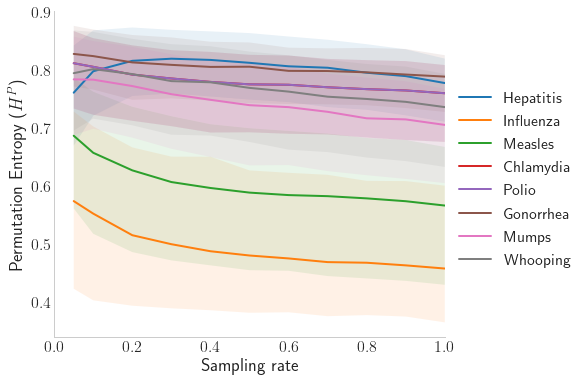

In [29]:
#plot entropy
fig, ax = plt.subplots(figsize=(7, 6))
for disease in diseases:
    plot_entropy(df_results, p_sample=p_sample, label=disease)

plt.legend(bbox_to_anchor=(1, 0.8), ncol=1)
plt.xlim(0,1.)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Sampling rate')
plt.ylabel(r'Permutation Entropy ($H^P$)')
plt.savefig(fig_folder/'epidemic_entropy_W52.pdf', bbox_inches='tight')

<ipython-input-17-cf34de2f2163>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ratio'] =  df1['entropy_sample']/df1['entropy']


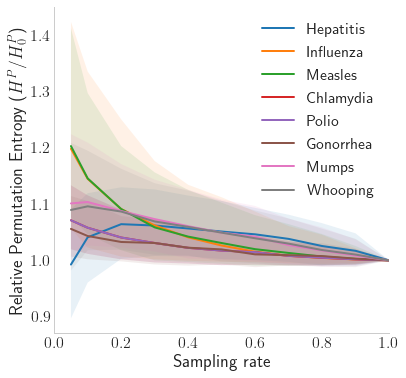

In [30]:
#plot entropy Ratio
fig, ax = plt.subplots(figsize=(6, 6))
for disease in diseases:
    plot_entropy_ratio(df_results, p_sample=p_sample, label=disease)

# plt.legend(bbox_to_anchor=(1, 0.8), ncol=1)
plt.legend( ncol=1)
plt.xlim(0,1.)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Sampling rate')
plt.ylabel(r'Relative Permutation Entropy ($H^P/H^P_0$)')
plt.savefig(fig_folder/'epidemic_entropy_ratio_W52.pdf', bbox_inches='tight')

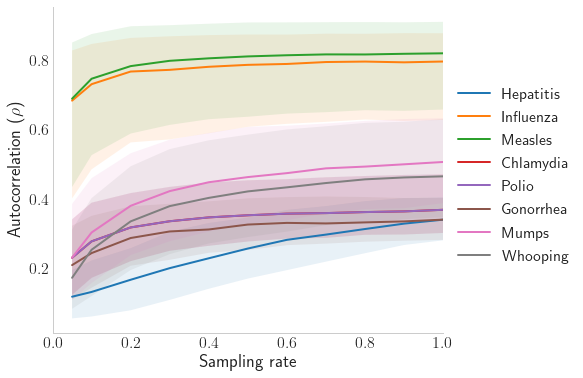

In [31]:
#plot autocorrelation 
fig, ax = plt.subplots(figsize=(7, 6))
for disease in diseases:
    plot_autocorr(df_results, p_sample, label=disease)
    

plt.legend(bbox_to_anchor=(1, 0.8), ncol=1)
plt.xlim(0,1.)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xlabel('Sampling rate')
plt.ylabel(r'Autocorrelation ($\rho$)')
plt.savefig(fig_folder/'epidemic_autocorr_W52.pdf', bbox_inches='tight')


<ipython-input-17-cf34de2f2163>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ratio'] =  df1['autcorr_sample']/df1['autocorr']


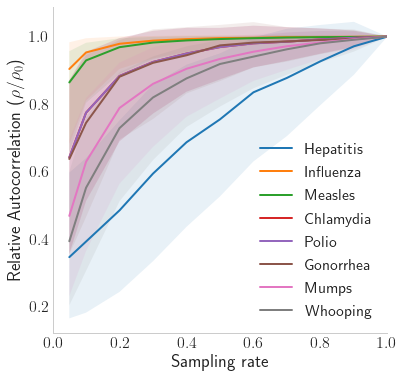

In [32]:
#plot autocorrelation  ratio
fig, ax = plt.subplots(figsize=(6, 6))
for disease in diseases:
    plot_autocorr_ratio(df_results, p_sample, label=disease)

# plt.legend(bbox_to_anchor=(1, 0.8), ncol=1)
plt.legend( ncol=1)
plt.xlim(0,1.)

ax.grid(color='grey', linestyle='--', linewidth=.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xlabel('Sampling rate')
plt.ylabel(r'Relative Autocorrelation ($\rho/\rho_0$)')
plt.savefig(fig_folder/'epidemic_autocorr_ratio_W52.pdf', bbox_inches='tight')

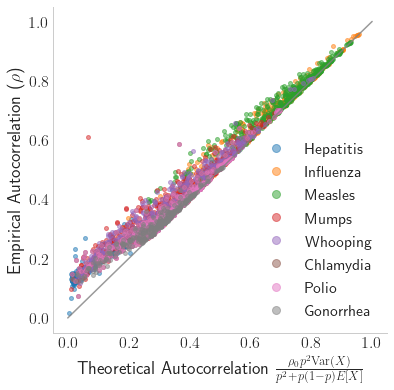

In [34]:
df = df_results.groupby(['state','disease','sample_rate']).mean()
df = df.reset_index()
# sns.lmplot(x="x_norm", y="ratio", scatter_kws={"s": 1,'alpha':0.05}, data=df)
fig, ax = plt.subplots(figsize=(6, 6))


for d in df.disease.unique():
    plot_df = df[df.disease==d]
    plt.plot(plot_df.x_norm, plot_df.autcorr_sample, '.', markersize=8, alpha=0.5, label = d )

plt.plot([0,1],[0,1], color='grey', alpha=0.8)
plt.legend(ncol=1,markerscale=2)
ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel(r'Theoretical Autocorrelation $\frac{\rho_0 p^2 \mathrm{Var}(X)}{p^2 + p(1-p)E[X]}$')
plt.ylabel(r'Empirical Autocorrelation ($\rho$)')
plt.savefig(fig_folder/'disease_theoretical.pdf', bbox_inches='tight')

# external signal

In [35]:
def week_to_date(x): 
    d =  str(x['YEAR'])+'-W'+ str(x['WEEK'])
    r = datetime.datetime.strptime(d + '-0', "%Y-W%W-%w")
    return r

In [41]:
data_folder = Path('Data/epidemics/')
influenza_df = pd.read_csv(data_folder/"ILINet.csv",skiprows=1, na_values="X")
influenza_df['date'] = influenza_df.apply(week_to_date, axis=1)
influenza_df['date']  = pd.to_datetime(influenza_df['date']).apply(lambda x: x.strftime('%Y-%m-%d'))
influenza_df = influenza_df.pivot_table(index = ['date'], columns=['REGION'], values=['TOTAL PATIENTS'])['TOTAL PATIENTS']
influenza_df.index = pd.to_datetime(influenza_df.index)
influenza_df.head()

google_df = pd.read_csv(data_folder/"google_flu.csv")
google_df['date']  = pd.to_datetime(google_df['date']).apply(lambda x: x.strftime('%Y-%m-%d'))
google_df.set_index('date', inplace=True)
google_df.index = pd.to_datetime(google_df.index)

start_day = max(influenza_df.index.min(),google_df.index.min())
end_date = min(influenza_df.index.max(),google_df.index.max())
day_range = pd.date_range(start_day, end_date, freq='W')
influenza_df = influenza_df[influenza_df.index>=start_day]
influenza_df = influenza_df[influenza_df.index<=end_date]
google_df = google_df[google_df.index>=start_day]
google_df = google_df[google_df.index<=end_date]


google_df.head()

,United States,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2010-10-10,1421,1007,1085.0,1449,2209.0,1295,508,593,1724.0,1561,...,689.0,1094,2244,565.0,689.0,1848,1339,2323.0,1445,387.0
2010-10-17,1566,1199,1161.0,1532,2430.0,1425,558,776,1870.0,1728,...,830.0,1090,2387,596.0,711.0,1979,1422,2431.0,1509,441.0
2010-10-24,1596,1309,1147.0,1648,2554.0,1624,682,763,1900.0,1821,...,823.0,1264,2304,658.0,779.0,2045,1473,2407.0,1663,488.0
2010-10-31,1685,1448,1224.0,1881,2731.0,1704,670,796,1984.0,1799,...,813.0,1385,2537,865.0,887.0,2129,1392,2630.0,1628,543.0
2010-11-07,1758,1625,1213.0,2152,2781.0,1655,651,836,2151.0,1846,...,886.0,1534,2775,783.0,883.0,2303,1541,2608.0,1760,620.0


In [45]:
#sample external and GT timeseries and compute correlation between them
p_sample = [1.,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]
df_results_ex = sample_ext_corr_window(influenza_df, google_df, window=52, n_samples=100, p_sample = p_sample )
df_results_ex.head()

Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming
finished


,state,sample_rate,sample_rate_ext,corr,corr_sample,cov,cov_sample,var,mean
0,Alabama,1.0,1.0,0.779697,0.779697,3.346178e+06,3.346178e+06,7.327893e+06,8541.711538
1,Alabama,1.0,0.9,0.779697,0.778794,3.346178e+06,3.015090e+06,7.327893e+06,8541.711538
2,Alabama,1.0,0.8,0.779697,0.780829,3.346178e+06,2.690820e+06,7.327893e+06,8541.711538
3,Alabama,1.0,0.7,0.779697,0.777258,3.346178e+06,2.345205e+06,7.327893e+06,8541.711538
4,Alabama,1.0,0.6,0.779697,0.779207,3.346178e+06,2.008067e+06,7.327893e+06,8541.711538


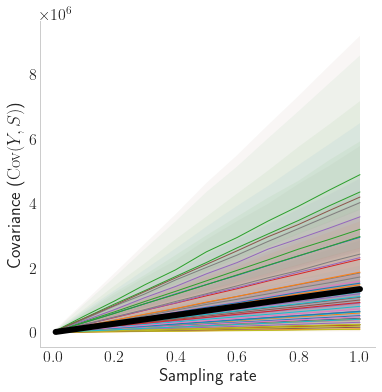

In [48]:
fig, ax = plt.subplots(figsize=(6, 6))
yy=[]
xx=[]
df = df_results_ex[df_results_ex['sample_rate_ext']==1.]
for state in df_results_ex.state.unique():
    x,y = plot_cov_ext_states(df, p_sample,state)
    yy.append(y)
    xx.append(x)
    

#Average of all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
plt.plot(x,y,label='Average', linewidth=6, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black')

# plt.legend( bbox_to_anchor=(1, 0.8), ncol=4)
ax.grid(color='grey', linestyle='--', linewidth=.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xlabel('Sampling rate')
plt.ylabel(r'Covariance ($\mathrm{Cov}(Y,S)$)')
plt.savefig(fig_folder/'epidemic_cov_ext_W52.pdf', bbox_inches='tight')

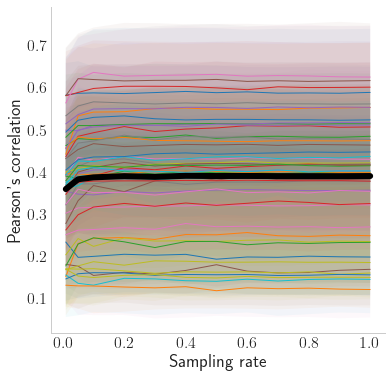

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))
yy=[]
xx=[]
df = df_results_ex[df_results_ex['sample_rate_ext']==1.]
for state in df_results_ex.state.unique():
    x,y = plot_corr_ext_states(df, p_sample,state)
    yy.append(y)
    xx.append(x)
    

#Average of all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
plt.plot(x,y,label='Average', linewidth=6, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black')

# plt.legend( bbox_to_anchor=(1, 0.8), ncol=4)
ax.grid(color='grey', linestyle='--', linewidth=.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xlabel('Sampling rate')
plt.ylabel("Pearson's correlation")
plt.savefig(fig_folder/'epidemic_corr_ext_W52.pdf', bbox_inches='tight')